### 1) Imports

In [1]:
import pennylane as qml

from pennylane import numpy as np
from pennylane.templates import RandomLayers

import tensorflow as tf
from tensorflow import keras

from matplotlib import pyplot as plt

import time

from itertools import product
from itertools import combinations_with_replacement

from collections import defaultdict

%run functions.ipynb

TRACK_AWS_BRAKET_COST = True

if TRACK_AWS_BRAKET_COST:    
    from braket.tracking import Tracker

2023-02-27 19:04:35.418978: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-02-27 19:04:35.526177: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-02-27 19:04:35.526195: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-02-27 19:04:36.060089: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-

In [2]:
# JAX

import jax
import jax.numpy as jnp

from jax.config import config

config.update("jax_enable_x64", True)


# GPUs

import os

JAX_EMULATED_DEVICES_COUNT = 8

XLA_FLAGS = f"--xla_force_host_platform_device_count={JAX_EMULATED_DEVICES_COUNT}"

os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = ", ".join(map(str, range(0, 16)))
os.environ['XLA_FLAGS'] = XLA_FLAGS

jax.devices()

2023-02-27 19:04:37.077581: W external/org_tensorflow/tensorflow/tsl/platform/default/dso_loader.cc:67] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2023-02-27 19:04:37.077623: W external/org_tensorflow/tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:264] failed call to cuInit: UNKNOWN ERROR (303)


[CpuDevice(id=0),
 CpuDevice(id=1),
 CpuDevice(id=2),
 CpuDevice(id=3),
 CpuDevice(id=4),
 CpuDevice(id=5),
 CpuDevice(id=6),
 CpuDevice(id=7)]

### 2) Parameters

In [3]:
QML_DEVICE_TYPES = [
    # "default.qubit",
    "lightning.qubit",
    # "lightning.gpu",
    # "lightning.gpu - multi-GPU",
    # "default.qubit.jax",
    # "braket.local.qubit",
    "braket.aws.qubit"
]

JAX_COMPATIBLE_DEVICES = ["default.qubit.jax", 
                          "braket.aws.qubit"]

parameters = create_parameters(qml_device_types=QML_DEVICE_TYPES,
                               jax_compatible_devices=JAX_COMPATIBLE_DEVICES,
                               image_width=20,
                               image_height=1,
                               min_filter_width=20,
                               min_filter_height=1,
                               min_filters_count=1,
                               max_filters_count=1)

### Run

In [4]:
image = load_one_MNIST_image()

image = image[8:]

# image = image[8:, 8:]

experiments = prepare_experiments(parameters)

Experiments count: 2


In [5]:
# plt.imshow(image);

In [6]:
run_experiments(experiments)

Experiment: 1/2
Device: lightning.qubit
Qubits per filter: 20
Filter repetitions: 1
Filter applications: 1


/home/mohor/.local/lib/python3.8/site-packages/pennylane/math/utils.py:223: UserWarning: Contains tensors of types {'autograd', 'jax'}; dispatch will prioritize TensorFlow, PyTorch, and  Jax over Autograd. Consider replacing Autograd with vanilla NumPy.
  warnings.warn(


Execution time: 0.25 seconds

Experiment: 2/2
Device: braket.aws.qubit
Qubits per filter: 20
Filter repetitions: 1
Filter applications: 1
Execution time: 9.06 seconds

AWS Braket Simulator Cost: 0.0038 USD
AWS Braket Tasks Statistics:


{'arn:aws:braket:::device/quantum-simulator/amazon/sv1': {'shots': 1000,
  'tasks': {'COMPLETED': 1},
  'execution_duration': datetime.timedelta(microseconds=29000),
  'billed_execution_duration': datetime.timedelta(seconds=3)}}

In [7]:
# np.save('new_experiments.npy', experiments)

### Visualization

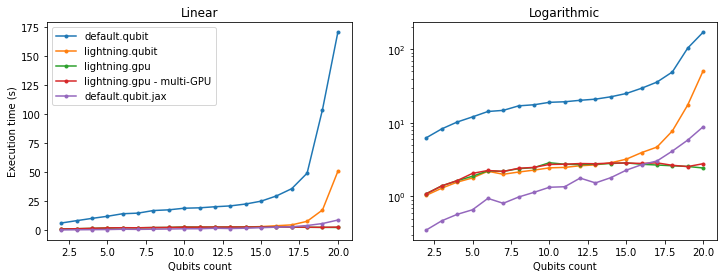

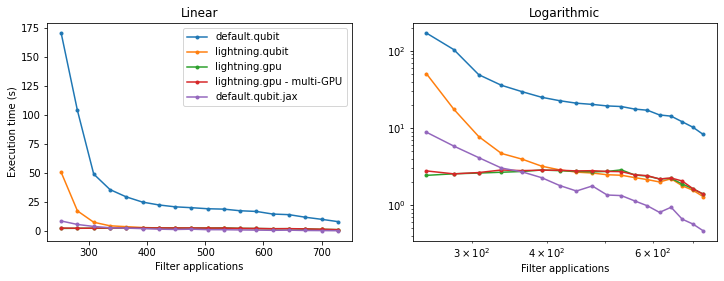

In [8]:
# 1 Filter

plt.style.use('default')

experiments = np.load('a100_jax_experiments_1_filter.npy', allow_pickle=True).item()

execution_times = aggregate_execution_times(experiments)

plot_time_per_qubit_counts(execution_times)

plot_time_per_filter_applications(execution_times)

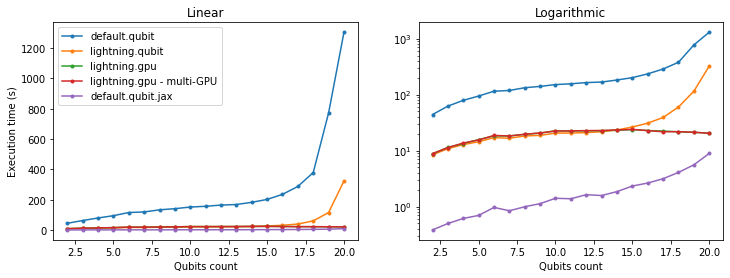

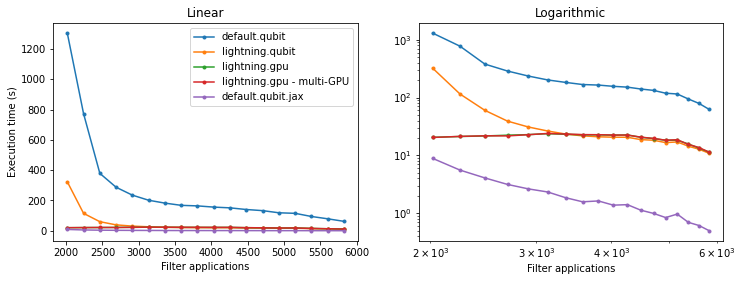

In [9]:
# 8 Filters

experiments = np.load('a100_jax_experiments_8_filters.npy', allow_pickle=True).item()

execution_times = aggregate_execution_times(experiments)

plot_time_per_qubit_counts(execution_times)

plot_time_per_filter_applications(execution_times)

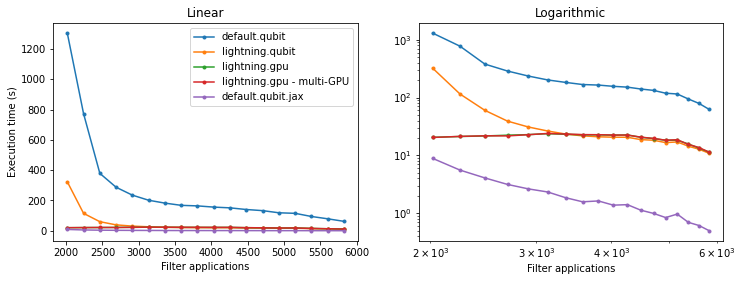

In [10]:
plot_time_per_filter_applications(execution_times)

#### Execution time per Filter applications count - 8 Filters

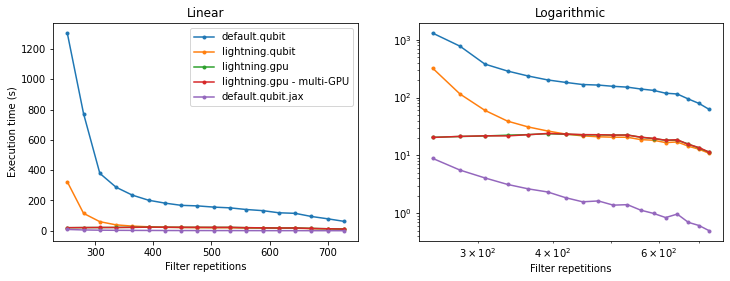

In [11]:
figure, (linear, logarithmic) = plt.subplots(1, 2, figsize=(12, 4))

for device_type in execution_times:
    
    filter_repetitions = execution_times[device_type]['filter_repetitions']
    execution_time = execution_times[device_type]['execution_time']
    
    # print("filter_repetitions:", filter_repetitions)
    # print("execution_time:", execution_time)

    linear.plot(filter_repetitions[2:], 
                execution_time[2:], 
                '.-', label=device_type)
    
    logarithmic.plot(filter_repetitions[2:], 
                     execution_time[2:], 
                     '.-', label=device_type)
    
linear.set_title("Linear")
linear.set_ylabel("Execution time (s)")
linear.set_xlabel("Filter repetitions")
# linear.set_yscale("log")
linear.legend()

logarithmic.set_title("Logarithmic")
logarithmic.set_xlabel("Filter repetitions")
logarithmic.set_xscale("log")
logarithmic.set_yscale("log")

plt.show()